In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2,baselinish3

from cs231n.data_utils import load_CIFAR10

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

In [3]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
(5000, 32, 32, 3)


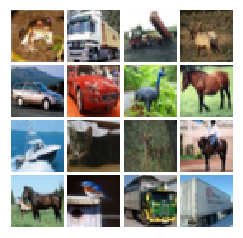

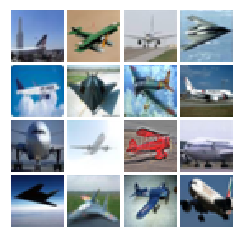

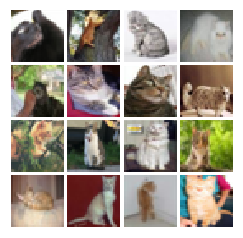

In [7]:
# Load the raw CIFAR-10 data.
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
show_images(X_train[:16])

arg_s = np.argsort(y_train)
y_train = y_train[arg_s]
X_train = X_train[arg_s]
show_images(X_train[:16])

X_cats = X_train[y_train == 3]
print (X_cats.shape)
show_images(X_cats[:16])

In [8]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha*x,x)

In [9]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    return D_solver, G_solver

In [10]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    G_loss = 0.5*tf.reduce_mean(tf.square(score_fake-1))
    D_loss = 0.5*tf.reduce_mean(tf.square(score_real-1) + tf.square(score_fake))
    return D_loss, G_loss

In [11]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        #reshaped_x = tf.transpose(x,perm = [0,2,3,1])
        reshaped_x = x
        a1 = tf.layers.conv2d(reshaped_x,filters = 32,kernel_size = [5,5],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [5,5],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 128,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 256,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.layers.conv2d(a1,filters = 512,kernel_size = [3,3],activation = leaky_relu,padding = 'same')
        a1 = tf.layers.max_pooling2d(a1,pool_size = [2,2],strides = [2,2])
        a1 = tf.reshape(a1,shape=[-1,512])
        a1 = tf.layers.dense(a1,512,activation = leaky_relu)
        logits = tf.layers.dense(a1,1)
        
        
        return logits

In [12]:
def generator(X):
    
    with tf.variable_scope("generator"):
        Float_image = X
        conv_mat = tf.constant(np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],[0.615,-0.514999,-0.10001]]),dtype = tf.float32)
        inv_conv_mat = tf.constant(np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]]),dtype = tf.float32)

        Float_image = tf.reshape(Float_image,[-1,3])

        YUV_image = tf.matmul(Float_image,conv_mat)
        YUV_image = tf.reshape(YUV_image,[-1,32,32,3])
        Float_image = tf.reshape(Float_image,[-1,32,32,3])
        UV_p = YUV_image[:,:,:,1:3]
        Y_p = YUV_image[:,:,:,0:1]

        a1 = tf.layers.conv2d(Y_p,filters = 16,kernel_size = [5,5],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [1,1],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 8,kernel_size = [1,1],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 2,kernel_size = [1,1],activation = tf.tanh,padding = 'same')



        a3 = tf.concat((Y_p,a1),axis = 3)
        #a2 = tf.image.hsv_to_rgb(a3)
        a3 = tf.reshape(a3,[-1,3])
        a2 = tf.matmul(a3,inv_conv_mat)
        RGB_out = tf.reshape(a2,[-1,32,32,3])

    
    return RGB_out,Y_p

In [13]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 32,32,3])
#z = sample_noise(batch_size, noise_dim)
# generated images
G_sample,G_in = generator(x)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [14]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(50000*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            rand_indices = np.random.choice(np.arange(49000),batch_size)
            minibatch = X_train[rand_indices]
            samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
            fig = show_images2(samples_gray[:16])
            plt.show()
            samples = sess.run(G_sample,feed_dict = {x:minibatch})
            fig = show_images(samples[:16])
            plt.show()
            fig = show_images(minibatch[:16])
            plt.show()
            
            print()
        # run a batch of data through the network
        #minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        rand_indices = np.random.choice(np.arange(49000),batch_size)
        minibatch = X_train[rand_indices]
        #print(minibatch.dtype)
        #print (minibatch.shape)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {x:minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    #print('Final images')
    #samples = sess.run(G_sample)

    #fig = show_images(samples[:16])
    #plt.show()

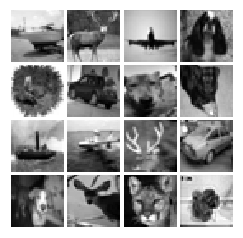

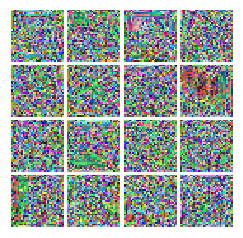

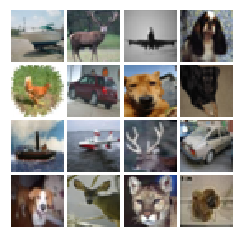


Iter: 0, D: 0.5064, G:3.427
Iter: 50, D: 0.009441, G:0.4779
Iter: 100, D: 0.1637, G:0.3178
Iter: 150, D: 0.1582, G:0.1888
Iter: 200, D: 0.2264, G:0.183


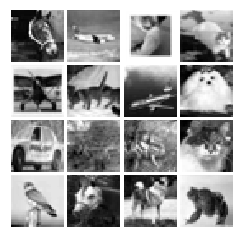

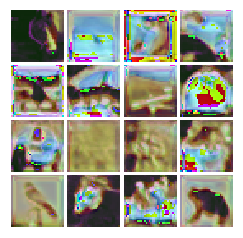

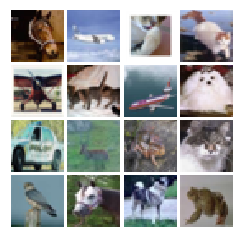


Iter: 250, D: 0.2455, G:0.2651
Iter: 300, D: 0.1745, G:0.2532
Iter: 350, D: 0.2426, G:0.1409
Iter: 400, D: 0.2274, G:0.1719
Iter: 450, D: 0.251, G:0.1393


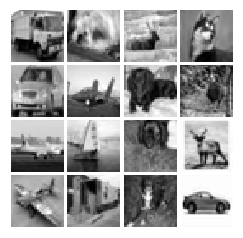

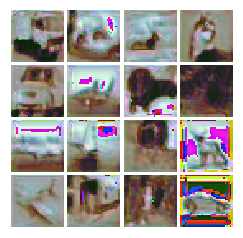

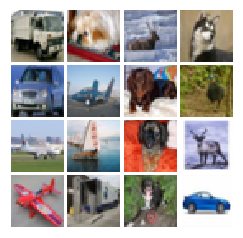


Iter: 500, D: 0.2491, G:0.1039
Iter: 550, D: 0.2467, G:0.1476
Iter: 600, D: 0.2505, G:0.1285
Iter: 650, D: 0.245, G:0.1293
Iter: 700, D: 0.2502, G:0.1235


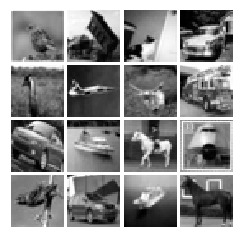

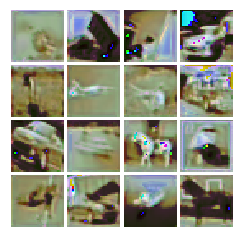

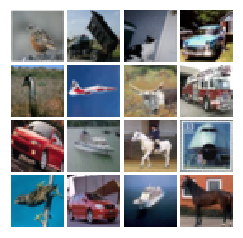


Iter: 750, D: 0.2497, G:0.06841
Iter: 800, D: 0.2461, G:0.1232
Iter: 850, D: 0.2469, G:0.1558
Iter: 900, D: 0.249, G:0.1558
Iter: 950, D: 0.2426, G:0.1287


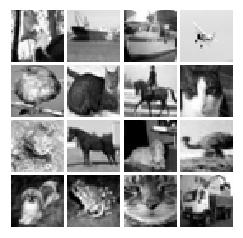

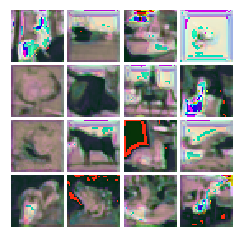

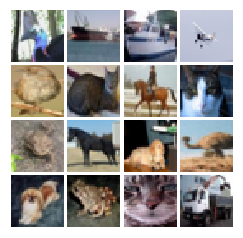


Iter: 1000, D: 0.256, G:0.1186
Iter: 1050, D: 0.2473, G:0.1305
Iter: 1100, D: 0.249, G:0.1432
Iter: 1150, D: 0.2467, G:0.136
Iter: 1200, D: 0.2445, G:0.1443


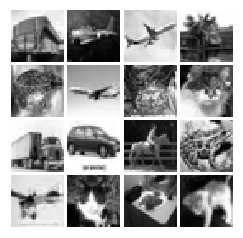

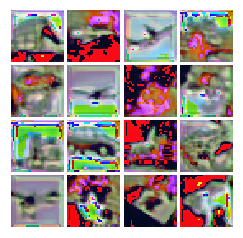

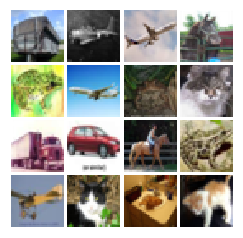


Iter: 1250, D: 0.2398, G:0.1266
Iter: 1300, D: 0.2476, G:0.1221
Iter: 1350, D: 0.2241, G:0.1496
Iter: 1400, D: 0.2477, G:0.1071
Iter: 1450, D: 0.2455, G:0.1258


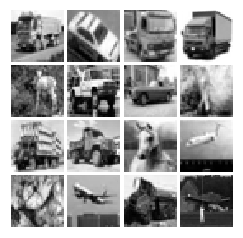

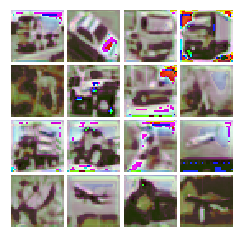

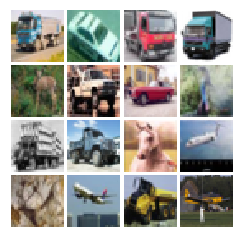


Iter: 1500, D: 0.2399, G:0.1469
Iter: 1550, D: 0.2344, G:0.1198
Iter: 1600, D: 0.2446, G:0.1599
Iter: 1650, D: 0.2468, G:0.1942
Iter: 1700, D: 0.2432, G:0.1324


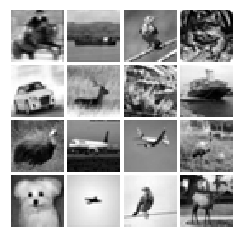

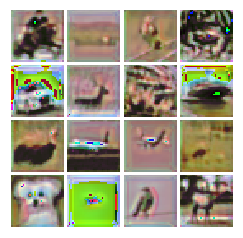

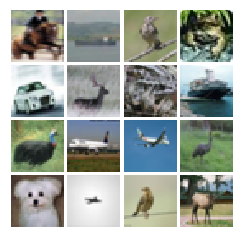


Iter: 1750, D: 0.2924, G:0.2069
Iter: 1800, D: 0.2385, G:0.1353
Iter: 1850, D: 0.2247, G:0.1352
Iter: 1900, D: 0.2417, G:0.1523
Iter: 1950, D: 0.2368, G:0.1458


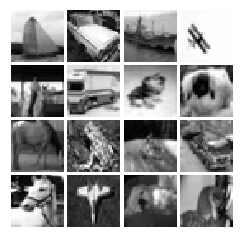

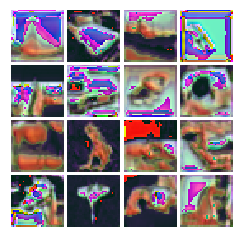

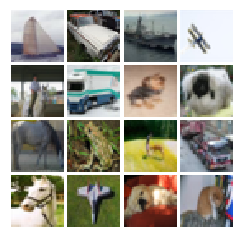


Iter: 2000, D: 0.2454, G:0.1225
Iter: 2050, D: 0.2236, G:0.1399
Iter: 2100, D: 0.2392, G:0.1368
Iter: 2150, D: 0.2631, G:0.2194
Iter: 2200, D: 0.2319, G:0.1783


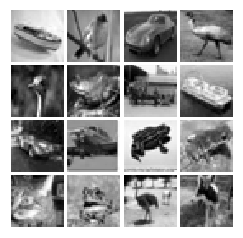

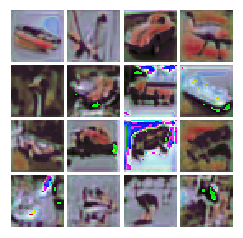

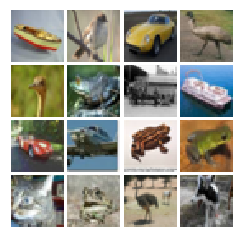


Iter: 2250, D: 0.2242, G:0.19
Iter: 2300, D: 0.2208, G:0.1429
Iter: 2350, D: 0.2144, G:0.1949
Iter: 2400, D: 0.2218, G:0.179
Iter: 2450, D: 0.2365, G:0.2127


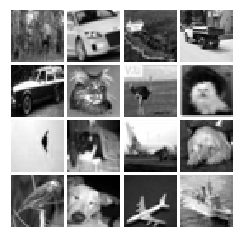

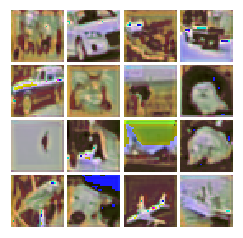

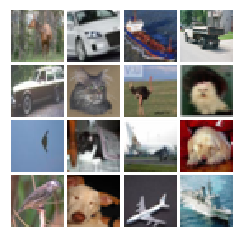


Iter: 2500, D: 0.19, G:0.2017
Iter: 2550, D: 0.2193, G:0.3095
Iter: 2600, D: 0.2025, G:0.2265
Iter: 2650, D: 0.1771, G:0.2341
Iter: 2700, D: 0.1953, G:0.2428


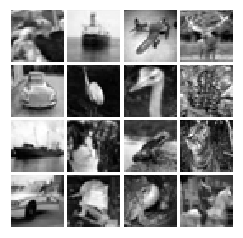

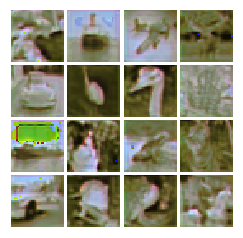

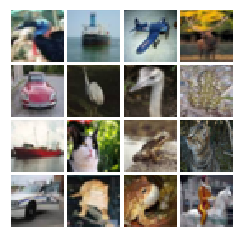


Iter: 2750, D: 0.1603, G:0.2366
Iter: 2800, D: 0.2569, G:0.2517
Iter: 2850, D: 0.2276, G:0.1253
Iter: 2900, D: 0.209, G:0.2131
Iter: 2950, D: 0.1969, G:0.1771


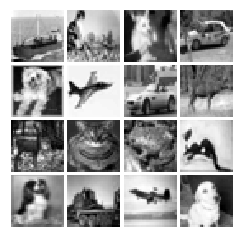

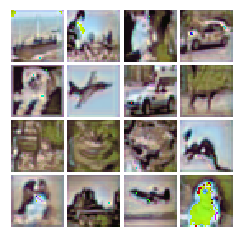

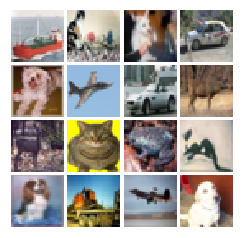


Iter: 3000, D: 0.2088, G:0.1957
Iter: 3050, D: 0.1487, G:0.2714
Iter: 3100, D: 0.2198, G:0.1747
Iter: 3150, D: 0.1976, G:0.2346
Iter: 3200, D: 0.2221, G:0.2315


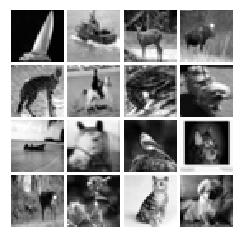

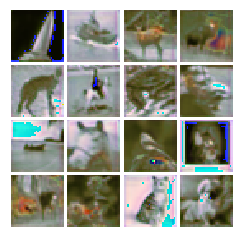

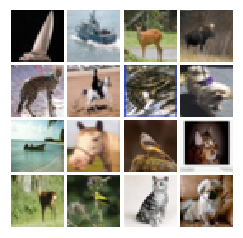


Iter: 3250, D: 0.207, G:0.2645
Iter: 3300, D: 0.2031, G:0.236
Iter: 3350, D: 0.1751, G:0.2375
Iter: 3400, D: 0.1992, G:0.1609
Iter: 3450, D: 0.2046, G:0.2168


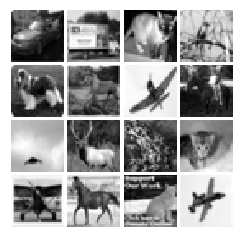

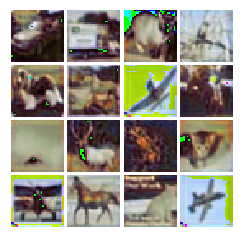

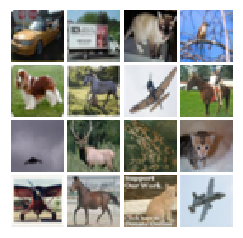


Iter: 3500, D: 0.2109, G:0.2281
Iter: 3550, D: 0.2033, G:0.2236
Iter: 3600, D: 0.1604, G:0.2849
Iter: 3650, D: 0.1677, G:0.2695
Iter: 3700, D: 0.1913, G:0.2073


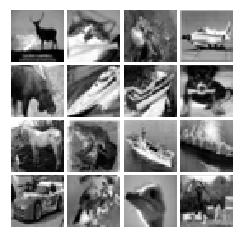

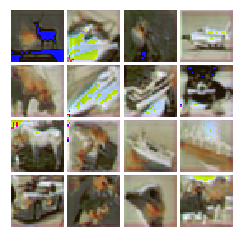

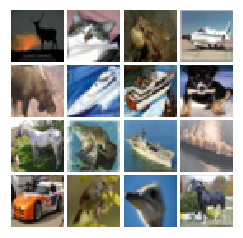


Iter: 3750, D: 0.1895, G:0.2459
Iter: 3800, D: 0.1674, G:0.3211
Iter: 3850, D: 0.1979, G:0.2489
Iter: 3900, D: 0.195, G:0.2399
Iter: 3950, D: 0.1098, G:0.3405


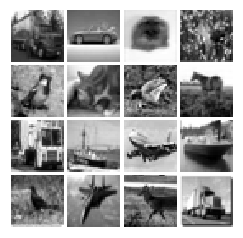

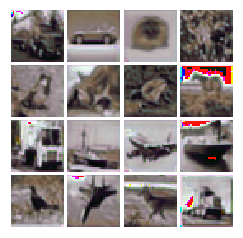

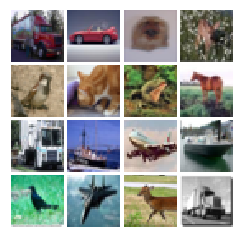


Iter: 4000, D: 0.1258, G:0.3305
Iter: 4050, D: 0.1582, G:0.2918
Iter: 4100, D: 0.1692, G:0.3013
Iter: 4150, D: 0.1898, G:0.2447
Iter: 4200, D: 0.1626, G:0.2905


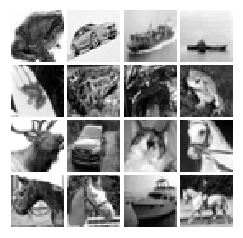

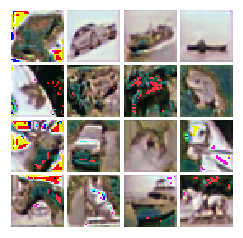

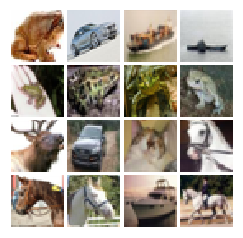


Iter: 4250, D: 0.1209, G:0.327
Iter: 4300, D: 0.1389, G:0.3397
Iter: 4350, D: 0.174, G:0.2409
Iter: 4400, D: 0.105, G:0.3611
Iter: 4450, D: 0.1364, G:0.2813


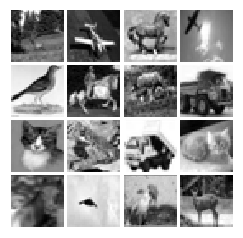

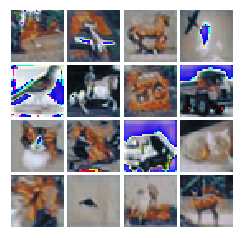

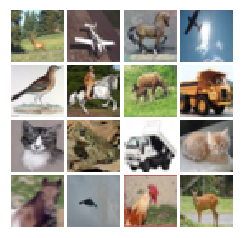


Iter: 4500, D: 0.1621, G:0.2846
Iter: 4550, D: 0.1609, G:0.2245
Iter: 4600, D: 0.1647, G:0.2398
Iter: 4650, D: 0.1452, G:0.3692
Iter: 4700, D: 0.1123, G:0.3424


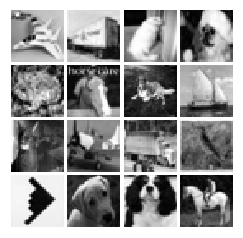

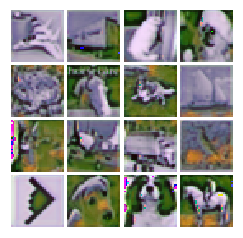

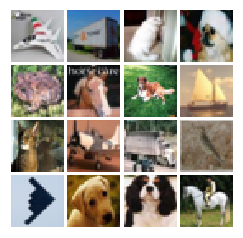


Iter: 4750, D: 0.1469, G:0.3497
Iter: 4800, D: 0.134, G:0.2892
Iter: 4850, D: 0.1322, G:0.3294
Iter: 4900, D: 0.1001, G:0.3629
Iter: 4950, D: 0.2188, G:0.3604


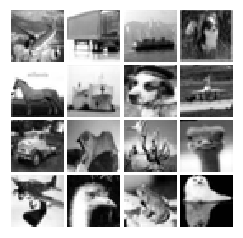

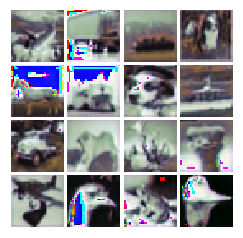

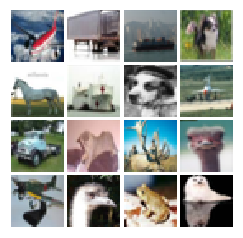


Iter: 5000, D: 0.1979, G:0.2199
Iter: 5050, D: 0.1499, G:0.4134
Iter: 5100, D: 0.1289, G:0.2836
Iter: 5150, D: 0.08199, G:0.3918
Iter: 5200, D: 0.1575, G:0.2498


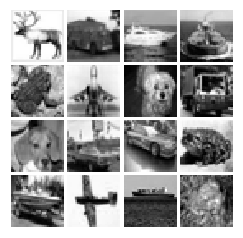

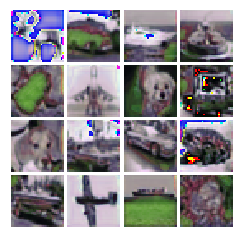

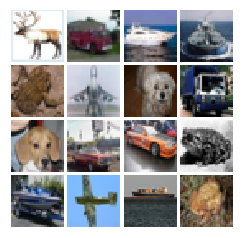


Iter: 5250, D: 0.1978, G:0.2431
Iter: 5300, D: 0.08265, G:0.3898


KeyboardInterrupt: 

In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,num_epoch = 20)

In [52]:
def augment_images(X):
    X = tf.image.convert_image_dtype(X,dtype = tf.float32)
    image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), X)
    image = tf.map_fn(lambda img: tf.image.random_brightness(img,max_delta=0.01),image)
    #image = tf.map_fn(lambda img: tf.image.random_contrast(img,lower=0, upper=0.2),image)
    return image



In [53]:
def generator(X):
    
    with tf.variable_scope("generator"):
        Float_image = X
        
        conv_mat = tf.constant(np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],[0.615,-0.514999,-0.10001]]),dtype = tf.float32)
        inv_conv_mat = tf.constant(np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]]),dtype = tf.float32)

        Float_image = tf.reshape(Float_image,[-1,3])

        YUV_image = tf.matmul(Float_image,conv_mat)
        YUV_image = tf.reshape(YUV_image,[-1,32,32,3])
        Float_image = tf.reshape(Float_image,[-1,32,32,3])
        UV_p = YUV_image[:,:,:,1:3]
        Y_p = YUV_image[:,:,:,0:1]
        noise = tf.random_uniform(shape = tf.shape(Y_p),minval = -0.02, maxval = 0.02)
        Y_p = Y_p + noise

        a1 = tf.layers.conv2d(Y_p,filters = 16,kernel_size = [5,5],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 64,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 32,kernel_size = [3,3],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 16,kernel_size = [1,1],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 8,kernel_size = [1,1],activation = tf.nn.relu,padding = 'same')
        a1 = tf.layers.batch_normalization(a1,training = True)
        a1 = tf.layers.conv2d(a1,filters = 2,kernel_size = [1,1],activation = tf.tanh,padding = 'same')



        a3 = tf.concat((Y_p,a1),axis = 3)
        #a2 = tf.image.hsv_to_rgb(a3)
        a3 = tf.reshape(a3,[-1,3])
        a2 = tf.matmul(a3,inv_conv_mat)
        RGB_out = tf.reshape(a2,[-1,32,32,3])

    
    return RGB_out,Y_p

In [54]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 32,32,3])
aug_x = augment_images(x)
#z = sample_noise(batch_size, noise_dim)
# generated images
G_sample,G_in = generator(x)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [55]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(50000*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            rand_indices = np.random.choice(np.arange(5000),batch_size)
            minibatch = X_cats[rand_indices]
            minibatch = sess.run([aug_x],feed_dict = {x:minibatch})[0]
            samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
            fig = show_images2(samples_gray[:16])
            plt.show()
            samples = sess.run(G_sample,feed_dict = {x:minibatch})
            fig = show_images(samples[:16])
            plt.show()
            fig = show_images(minibatch[:16])
            plt.show()
            
            print()
        # run a batch of data through the network
        #minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        rand_indices = np.random.choice(np.arange(5000),batch_size)
        minibatch = X_cats[rand_indices]
        minibatch = sess.run([aug_x],feed_dict = {x:minibatch})[0]
        #print(minibatch.dtype)
        #print (minibatch.shape)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict = {x:minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    #print('Final images')
    #samples = sess.run(G_sample)

    #fig = show_images(samples[:16])
    #plt.show()

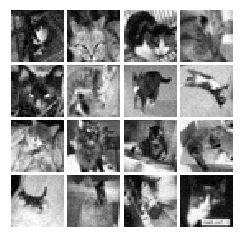

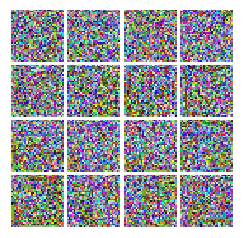

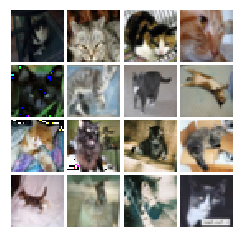


Iter: 0, D: 0.4869, G:2.043


KeyboardInterrupt: 

In [56]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,num_epoch = 20)

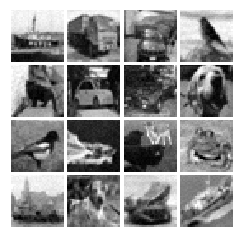

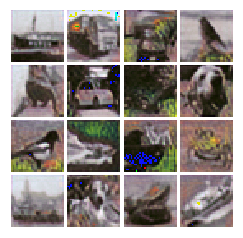

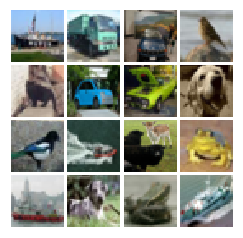

In [46]:
rand_indices = np.random.choice(np.arange(49000),batch_size)
minibatch = X_train[rand_indices]
samples_gray = sess.run(G_in,feed_dict = {x:minibatch})
fig = show_images2(samples_gray[:16])
plt.show()
samples = sess.run(G_sample,feed_dict = {x:minibatch})
fig = show_images(samples[:16])
plt.show()
fig = show_images(minibatch[:16])
plt.show()
            

In [ ]:
saver = tf.train.Saver()
saver.save(sess,'gan_model_cats')